In [2]:
import functools
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from tqdm.auto import trange

sys.path.append("..")

from kuramoto.approximator import KuramotoApproximator
from kuramoto.plot import plot_image
from kuramoto.trajectory import (IsDivergingPrecise, compare_trajectory,
                                 get_order_parameter)
from neural_rk import fitting
from neural_rk.hyperparameter import HyperParameter
from neural_rk.modules import RungeKutta, prune_state_dict
from neural_rk.path import DATA_DIR, FIG_DIR, RESULT_DIR
from neural_rk.scheduler import get_scheduler
from neural_rk.trainer import rollout

mpl.rcParams["font.family"] = "serif"
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath, amssymb}"

In [14]:
device = torch.device("cuda:1")
exp_id = "A"
test_id = "A_train"

result_dir = RESULT_DIR / f"kuramoto_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load data
test_df = pd.read_pickle(DATA_DIR / f"kuramoto_{test_id}.pkl")
times = np.array(
    [np.insert(np.cumsum(dts.numpy()), 0, 0.0) for dts in test_df.dts],
    dtype=np.float32,
)
true_trajectories = [traj.numpy() for traj in test_df.trajectories]

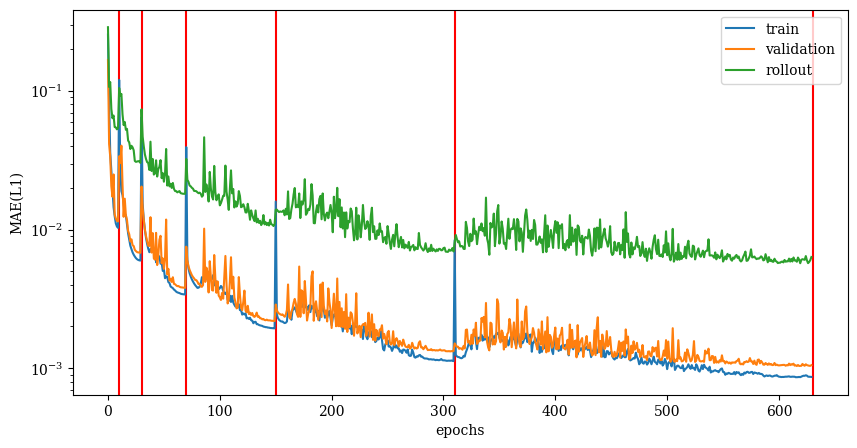

In [4]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

In [15]:
approximator = KuramotoApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
# model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

kuramoto_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)


# Rollout

In [16]:
pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(kuramoto_rollout(series=test_df.iloc[idx]).cpu().numpy())


  0%|          | 0/200 [00:00<?, ?it/s]

In [17]:
with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
    pickle.dump(pred_trajectories, f)

# with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
#     pred_trajectories = pickle.load(f)

# Analyze

In [18]:
maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # (# of samples, S)
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, er, N=89 MAE=0.0045, Maximum err: 0.0705 at step=454, node=37
idx=1, rr, N=119 MAE=0.0021, Maximum err: 0.0426 at step=446, node=83
idx=2, rr, N=123 MAE=0.0024, Maximum err: 0.4744 at step=500, node=10
idx=3, rr, N=69 MAE=0.0026, Maximum err: 0.0725 at step=415, node=29
idx=4, er, N=55 MAE=0.0472, Maximum err: 4.1779 at step=500, node=7
idx=5, er, N=53 MAE=0.0028, Maximum err: 0.0436 at step=489, node=45
idx=6, rr, N=83 MAE=0.0019, Maximum err: 0.0330 at step=500, node=7
idx=7, er, N=112 MAE=0.0021, Maximum err: 0.0376 at step=402, node=103
idx=8, rr, N=149 MAE=0.0025, Maximum err: 0.0591 at step=314, node=52
idx=9, rr, N=82 MAE=0.0022, Maximum err: 0.0429 at step=500, node=68
idx=10, er, N=56 MAE=0.0018, Maximum err: 0.0134 at step=364, node=30
idx=11, rr, N=138 MAE=0.0029, Maximum err: 0.0797 at step=419, node=101
idx=12, ba, N=138 MAE=0.0041, Maximum err: 0.1385 at step=372, node=125
idx=13, ba, N=86 MAE=0.0031, Maximum err: 0.1695 at step=500, node=0
idx=14, er, N=109 MAE=0.

## Single sample

In [9]:
sample_idx = 31

print(test_df.network_type[sample_idx])
xticks = np.round(np.linspace(0, times[sample_idx, -1], 5), 2)
true_trajcetory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]
error = true_trajcetory - pred_trajectory

print(f"{error.min() / np.pi:.2f}pi < error < {error.max() / np.pi:.2f}pi")

rr
-0.02pi < error < 0.01pi


plot node with index: [  2   3  67  66   8 104  74  43  78  16]


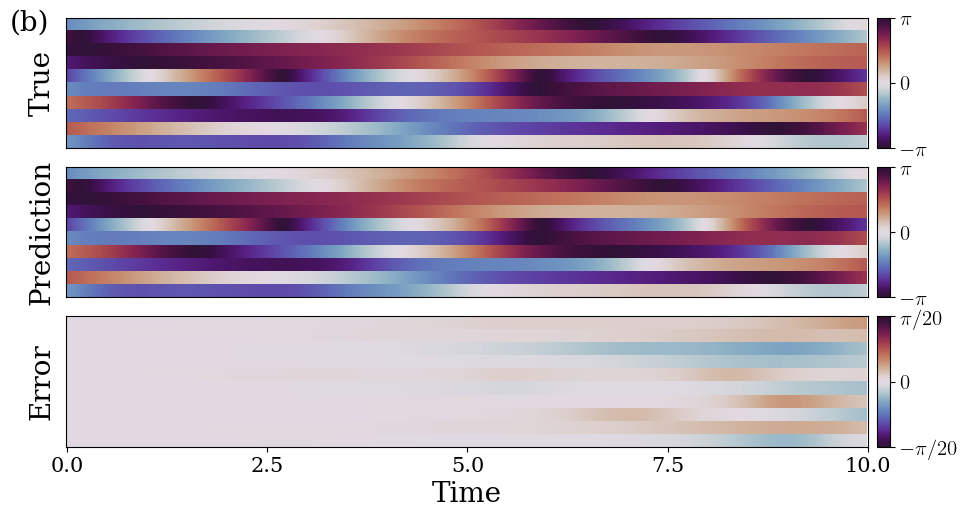

In [11]:
# nodes = np.random.choice(np.arange(true_trajcetory.shape[1]), 10, replace=False)
nodes = set()
for idx in np.argsort(np.abs(error).sum(axis=0).flatten())[::-1]:  # max
    # for idx in np.argsort(np.abs(error).sum(axis=0).flatten()):   # min
    idx = np.unravel_index(idx, error.shape[1:])
    nodes.add(idx[0])
    if len(nodes) == 10:
        break
nodes = np.array(list(nodes), dtype=np.int64)
print(f"plot node with index: {nodes}")

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)
ax1.set_ylabel("True", fontsize=20)
im = plot_image(
    ax1,
    true_trajcetory,
    nodes,
    xticks=xticks,
)
cbar1 = fig.colorbar(
    im, ax=ax1, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi], aspect=10
)
ax1.set_xticks([])
cbar1.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)
cbar1.ax.tick_params(labelsize=15)

ax2.set_ylabel("Prediction", fontsize=20)
im = plot_image(
    ax2,
    pred_trajectory,
    nodes,
    xticks=xticks,
)
cbar2 = fig.colorbar(
    im, ax=ax2, location="right", pad=0.01, ticks=[-np.pi, 0, np.pi], aspect=10
)
ax2.set_xticks([])
cbar2.ax.set_yticklabels([r"$-\pi$", 0, r"$\pi$"], usetex=True)
cbar2.ax.tick_params(labelsize=15)

ax3.set_ylabel("Error", fontsize=20)
im = plot_image(
    ax3,
    error,
    nodes,
    lim=(-0.05 * np.pi, 0.05 * np.pi),
    xticks=xticks,
)
cbar3 = fig.colorbar(
    im,
    ax=ax3,
    location="right",
    pad=0.01,
    ticks=[-0.05 * np.pi, 0, 0.05 * np.pi],
    aspect=10,
)
ax3.set_xlabel("Time", fontsize=20)
ax3.tick_params(axis="x", labelsize=15)
cbar3.ax.set_yticklabels([r"$-\pi/20$", 0, r"$\pi/20$"], usetex=True)
cbar3.ax.tick_params(labelsize=15)

ax1.text(-0.07, 0.9, "(b)", transform=ax1.transAxes, fontsize=20)

fig.tight_layout(pad=0.0)
# fig.savefig(
#     f"{FIG_DIR}/kuramoto_{test_id}_{sample_idx}_{exp_id}.pdf",
#     bbox_inches="tight",
#     pad_inches=0.0,
# )
fig.show()

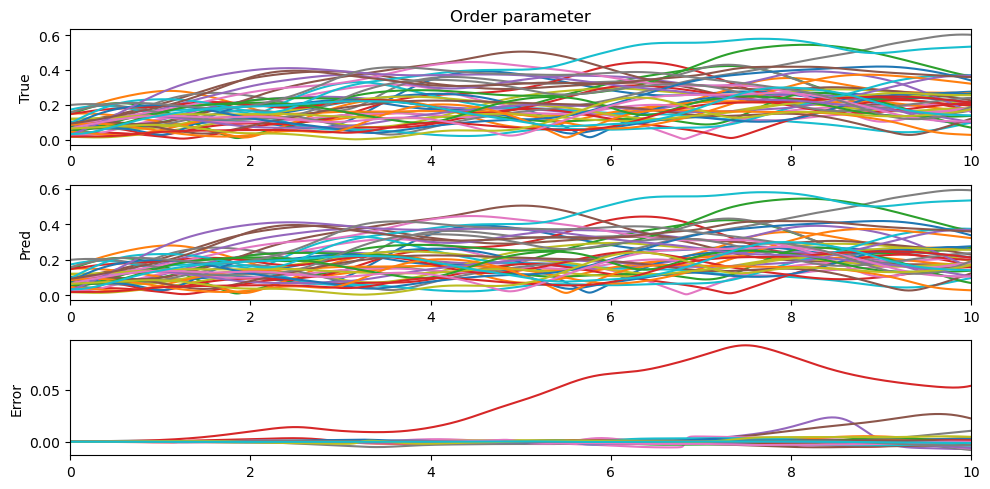

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

for t, true_traj, pred_traj in zip(times, true_trajectories, pred_trajectories):
    true_op, pred_op = get_order_parameter(true_traj), get_order_parameter(pred_traj)
    ax1.plot(t, true_op)
    ax2.plot(t, pred_op)
    ax3.plot(t, true_op - pred_op)

ax1.set_xlim(0.0, 10.0)
ax1.set_ylabel("True")
ax1.set_title("Order parameter")
ax2.set_xlim(0.0, 10.0)
ax2.set_ylabel("Pred")
ax3.set_xlim(0.0, 10.0)
ax3.set_ylabel("Error")


fig.tight_layout()
fig.show()

## Statisics over samples

slope: 0.0808 pm 0.0418
slope of averaged curve: 0.0755


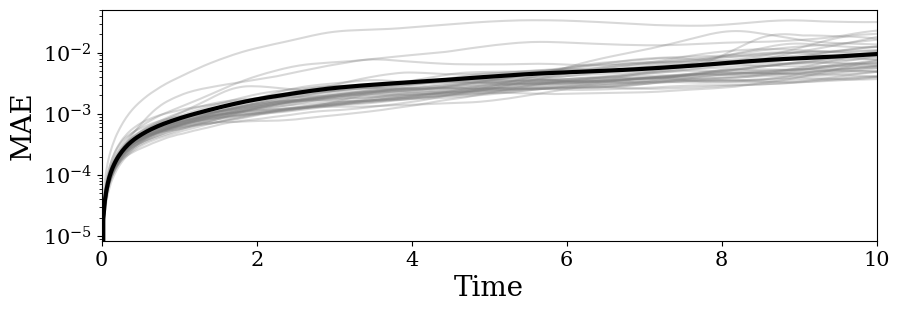

In [13]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 4.0, "log"

fig, ax = plt.subplots(figsize=(10, 3))

slopes = []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, maes):
    ax.plot(sample_time, sample_mae, color="gray", alpha=0.3)
    # ax.plot(sample_time, sample_mae, color=colors[network_type], alpha=0.3)

    mask = sample_time > fit_range
    if yscale == "log":
        *_, slope, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask])
    else:
        *_, slope, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask])
    slopes.append(slope)


final_mae = np.mean(maes, 0)
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
ax.plot(t, final_mae, "k-", linewidth=3)

mask = t > fit_range
if yscale == "log":
    fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
else:
    fit_t, fit_mae, slope, _ = fitting.lin_fit(t[mask], final_mae[mask])
print(f"slope: {np.mean(slopes):.4f} pm {np.std(slopes):.4f}")
print(f"slope of averaged curve: {slope:.4f}")
# ax.plot(fit_t, fit_mae, "r-", label=f"{np.mean(slopes):.4f}")
# ax.legend()

if yscale == "log":
    ax.set_yscale("log")
ax.set_xlim(left=0)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("MAE", fontsize=20)
ax.tick_params(axis="both", labelsize=15)
ax.set_xlim(0.0, 10.0)
# fig.savefig(
#     f"{FIG_DIR}/kuramoto_mae_{test_id}_{exp_id}.pdf",
#     bbox_inches="tight",
#     pad_inches=0.0,
# )
fig.show()